In [1]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
import warnings
from plot_utils import plot_pearsonr, plot_model_metrics
warnings.filterwarnings("ignore")

### 读取数据

In [2]:
path = './data/descriptor_binary.csv'
df = pd.read_csv(path)
x = df.drop(['shell_number'], axis=1)
y = df['shell_number']
# print(df.shape)
# display(df.head())
# print(x.shape, y.shape)
# print(y.value_counts())

### 数据分析

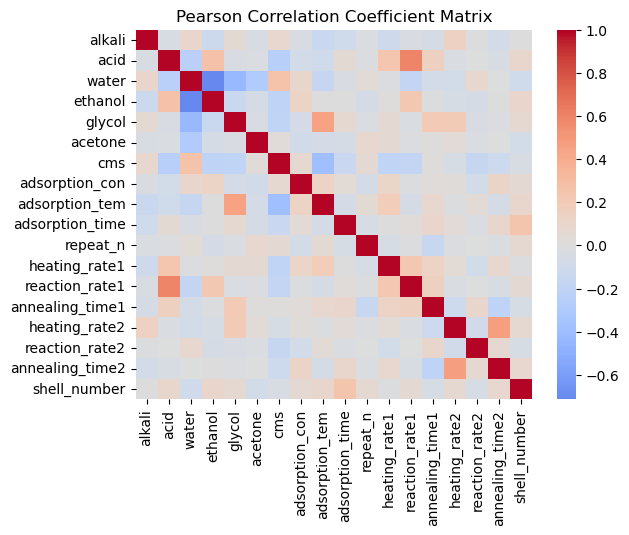

In [3]:
plot_pearsonr(df.iloc[:,24:])

### 分割数据

In [4]:
random_state = 11
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
# print(x_train.shape, y_train.shape)
# print(y_train.value_counts())

In [5]:

ros = RandomOverSampler(random_state=random_state)
x_resampled, y_resampled = ros.fit_resample(x_train, y_train)
# print(x_resampled.shape, y_resampled.shape)
# print(y_resampled.value_counts())

### 常用模型构建

In [6]:
# 神经网络模型
mlp = MLPClassifier(
    activation='relu',
    solver='adam', 
    hidden_layer_sizes=(4), 
    max_iter=1000,
    random_state=random_state
)
# 随机森林模型
rf = RandomForestClassifier(random_state=random_state)
# 梯度提升树模型
gbdt = GradientBoostingClassifier(random_state=random_state)
# 支持向量机
svc = SVC(random_state=random_state)
# k-近邻方法
knn = KNeighborsClassifier()

models = {
    'mlp':mlp,
    'rf':rf,
    'gbdt':gbdt,
    'svc':svc,
}

In [7]:
skf = StratifiedKFold(n_splits=10,shuffle=True, random_state=random_state)
scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall_macro',
    'precision': 'precision_macro',
    'f1': 'f1_macro',
}

results = {}
for name, model in models.items():
    eva = {}
    cv_results = cross_validate(model, x, y, cv=skf, scoring=scoring)
    eva['accuracy'] = cv_results['test_accuracy'].mean()
    eva['recall'] = cv_results['test_recall'].mean()
    eva['precision'] = cv_results['test_precision'].mean()
    eva['f1'] = cv_results['test_f1'].mean()
    results[name] = eva

results_df = pd.DataFrame(results).T.reset_index()
results_df.columns = ['model', 'accuracy', 'recall', 'precision', 'f1']
print(results_df)


  model  accuracy    recall  precision        f1
0   mlp  0.718649  0.524457   0.527607  0.503089
1    rf  0.743750  0.596713   0.628980  0.585103
2  gbdt  0.766129  0.623978   0.681904  0.625113
3   svc  0.750000  0.500000   0.375000  0.428557


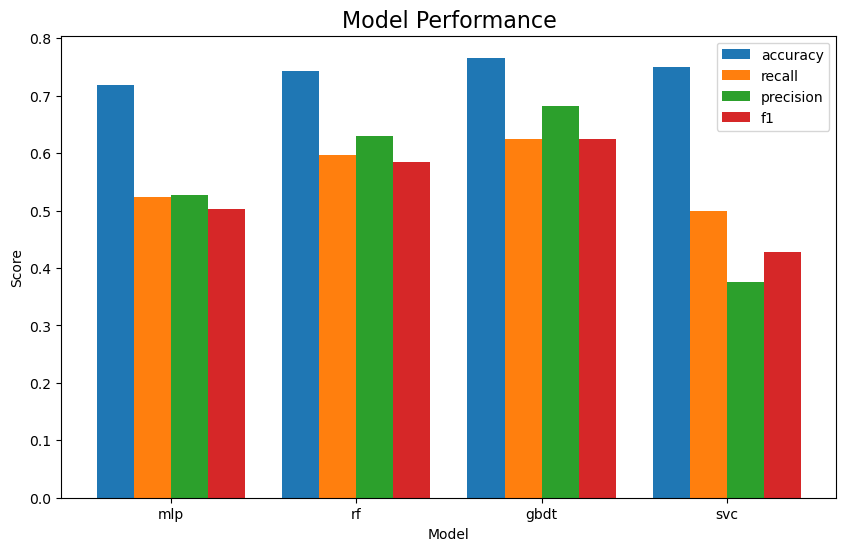

In [8]:
plot_model_metrics(results_df, results_df.columns[1:])